In [1]:
#!/usr/bin/env python3

In [2]:
%matplotlib inline
import numpy as np 
import time 
from datetime import timedelta
import tensorflow as tf
from readImages import *
from build_tensorflow_graph import *
import matplotlib.pyplot as plt
import math

In [3]:
#
## ---------- VAE Architecture ----------
#

# Convolution Layer 1
numFilters1 = 16
cnnArchitecture1 = CNN_Architecture(numFilters = numFilters1, 
                                    filterSize = (3, 3), 
                                    strides = 1, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = 3, 
                                    maxPoolingSize=None)

dcnnArchitecture1 = CNN_Architecture(numFilters = 3, 
                                    filterSize = (3, 3), 
                                    strides = 1, 
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = numFilters1, 
                                    maxPoolingSize=None)


# Convolution Layer 2
numFilters2 = 32
cnnArchitecture2 = CNN_Architecture(numFilters = numFilters2, 
                                    filterSize = (3, 3), 
                                    strides = 1, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters1, 
                                    maxPoolingSize=None)

dcnnArchitecture2 = CNN_Architecture(numFilters = numFilters1, 
                                    filterSize = (3, 3), 
                                    strides = 1, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters2, 
                                    maxPoolingSize=None)


# Convolution Layer 3
numFilters3 = 64
cnnArchitecture3 = CNN_Architecture(numFilters = numFilters3,
                                    filterSize = (3, 3), 
                                    strides = 1, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters2, 
                                    maxPoolingSize=None)
dcnnArchitecture3 = CNN_Architecture(numFilters = numFilters2,
                                    filterSize = (3, 3), 
                                    strides = 1, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters3, 
                                    maxPoolingSize=None)

# Fully Connected 1
fc1_size = 1024 
# Fully Connected 2
fc2_size = 512
# Lattern Code 
z_dim = 256

In [4]:
#  
#    input layer: 64 * 64 * 3 = 12288
#    conv1 layer: 64 * 64 * 16 = 131072 / 2
#    conv2 layer: 64 * 64 * 32 = 131072
#    conv3 layer: 64 * 64 * 64 = 262144
#    fc1_size = 1024
#    fc2_size = 512
#    z_dim = 256

In [5]:
class Image:
    """
    Structure for input images
    """
    size = 40
    numChannels = 3

In [6]:
class VAE:
    def __init__(self, batch_size, criterion="cross-entropy"):
        self.batch_size = batch_size 
        self.sess = tf.Session()
        # ---------- build model ----------
        bs = self.batch_size
        self.inputImages = tf.placeholder(tf.float32, 
                                          shape=[bs, Image.size, Image.size, Image.numChannels])
        self.lattenCode = tf.placeholder(tf.float32, shape= [None, z_dim])
        self.mu, self.sigma = self.encoder(self.inputImages, is_training=True, reuse=False)
        z = self.mu + \
               self.sigma * tf.random_normal(tf.shape(self.mu), 0, 1, dtype=tf.float32)
        
        # Reconstruct
        reconstruct = self.decoder(z, is_training=True, reuse=False)
        self.reconstruct = tf.clip_by_value(reconstruct, 1e-8, 1 - 1e-8)
        
        # Define Cost
        regularizer = tf.reduce_sum(tf.exp(self.sigma) - (1 + self.sigma) + tf.square(self.mu) , axis = 1)
        if criterion.lower() == 'cross-entropy':
            cross_entropy = tf.reduce_sum(self.inputImages * tf.log(self.reconstruct) + \
                                           (1 - self.inputImages) * tf.log(1 - self.reconstruct), axis = [1, 2, 3])
            self.cost = tf.reduce_mean(regularizer - cross_entropy)
        elif criterion.lower() == 'lms':
            lms = tf.reduce_sum(tf.square(self.inputImages - self.reconstruct), axis = [1, 2, 3])
            self.cost = tf.reduce_mean(regularizer + lms)       
        
        else:
            assert False, "Wrong Argument!! criterion must be lms or cross-entropy"
            
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.cost)
        
        # Testing
        self.fake_images = self.decoder(self.lattenCode, is_training=False, reuse=True)
        
        
    def encoder(self, inputLayer, is_training = True, reuse = False):
        with tf.variable_scope("encoder", reuse = reuse):
            conv1, convWeights1 = new_convLayer(inputLayer, cnnArchitecture1, name="en_conv1")
            conv2, convWeights2 = new_convLayer(conv1, cnnArchitecture2, name="en_conv2")
            conv2 = bn(conv2, is_training=is_training, scope="en_bn2")
            conv3, convWeights3 = new_convLayer(conv2, cnnArchitecture3, name="en_conv3")
            conv3 = bn(conv3, is_training=is_training, scope="en_bn3")
            flat_layer, numAttrs = flattenLayer(conv3)
            
            self.flat_numAttrs = (numAttrs)
            
            fc1 = new_fcLayer(flat_layer, 
                              inputChannels = numAttrs, 
                              outputChannels = fc1_size,
                              useReLU=True, 
                              name = "en_fc4")
            fc1 = bn(fc1, is_training=is_training, scope="en_bn4")
            fc2 = new_fcLayer(fc1, 
                              inputChannels = fc1_size, 
                              outputChannels = fc2_size,
                              useReLU=True, 
                              name = "en_fc5")
            fc2 = bn(fc2, is_training=is_training, scope="en_bn5")
            gaussian_para = new_fcLayer(fc2, 
                                        inputChannels = fc2_size, 
                                        outputChannels = z_dim * 2,
                                        useReLU=False, 
                                        name = "en_fc6")
            mean = gaussian_para[:, :z_dim]
            stdev = tf.exp(gaussian_para[:, z_dim:])
            return mean, stdev
        
    def decoder(self, lattenCode, is_training = True, reuse = False):
        with tf.variable_scope("decoder", reuse=reuse):
            dfc2 = new_fcLayer(lattenCode, 
                               inputChannels = z_dim, 
                               outputChannels = fc2_size,
                               useReLU=True, 
                               name = "de_fc1")
            dfc2 = bn(dfc2, is_training=is_training, scope="de_bn1")
            dfc1 = new_fcLayer(dfc2, 
                               inputChannels = fc2_size, 
                               outputChannels = fc1_size, 
                               useReLU = True, 
                               name = "de_fc2")
            dfc1 = bn(dfc1, is_training=is_training, scope="de_bn2")
            dflat = new_fcLayer(dfc1, 
                                inputChannels = fc1_size,  
                                outputChannels = self.flat_numAttrs, 
                                useReLU = True, 
                                name = "de_conv3")
            dflat = bn(dflat, is_training=is_training, scope="de_bn3")
            dconv3 = tf.reshape(dflat, shape=[-1, Image.size, Image.size, numFilters3])
            
            dconv2 =  new_dconvLayer(dconv3, dcnnArchitecture3, 
                                     [self.batch_size, Image.size, Image.size, numFilters2], name = "de_conv4")
            dconv2 = bn(dconv2, is_training=is_training, scope="de_bn4")
            dconv1 =  new_dconvLayer(dconv2, dcnnArchitecture2, 
                                     [self.batch_size, Image.size, Image.size, numFilters1], name = "de_conv5")
            dconv1 = bn(dconv1, is_training=is_training, scope="de_bn5")
            reconstruct = new_dconvLayer(dconv1, dcnnArchitecture1, 
                                         [self.batch_size, Image.size, Image.size, Image.numChannels], name = "de_conv6")
            reconstruct = tf.nn.sigmoid(reconstruct)
            return reconstruct
    def train(self, fileDir, epochs = 100, saveModel = False):
        costHistory = []
        start = time.time()
        print('  * Start Training ...')
        self.sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            print('  * processing epoch #{} '.format(epoch))
            count = 0
            for batch in readImagesIn(directory=fileDir, size=(Image.size, Image.size), noiseStdev=0.0, batch_size = self.batch_size):
                count += 1
                feed_dict_train = {self.inputImages : batch}
                _, cost = self.sess.run([self.optimizer, self.cost],feed_dict = feed_dict_train)
                costHistory.append(cost)
                
                if count % 50 == 1:
                    print('\tepoch #{} , iterations #{}, cost = {}'.format(epoch, count, cost))
                    
            print('\tDONE! cost: {}'.format(cost))
                
        
        ## TODO...
        # Dst tensor is not initialized Error while saving model
        if saveModel:
            saver = tf.train.Saver()
            save_path = saver.save(self.sess, "../models/model.ckpt")
            print("  * Model saved in path: %s" % save_path)
        # -------- Plot Learning Curve --------
        plt.figure()
        plt.title('Learning Curve')
        plt.xlabel('# Iterations')
        plt.ylabel('Cost (LMS + KL_Divergence)')
        plt.plot(costHistory)
        plt.savefig('../figure/VAE/LearningCurve.png')
            
        
    def generateFakeImages(self):
        z = np.random.normal(0, 1, size=(self.batch_size, z_dim))
        feed_dict_test = {self.lattenCode : z }
        fakeImg = self.sess.run(self.fake_images, feed_dict=feed_dict_test)
        return fakeImg

In [7]:
if __name__ == '__main__':
    directory = '../faces/'
#     imgs = readImagesIn(directory=directory, size=(64, 64), noiseStdev=0.03)
    
    batch_size = 64
    print('  * Building Model ...', end="")
    vae = VAE(batch_size=batch_size)
    print('  Finished!!')
    
    

  * Building Model ...  Finished!!


  * Start Training ...
  * processing epoch #0 
	epoch #0 , iterations #1, cost = 3553.20947265625
	epoch #0 , iterations #51, cost = 3177.878173828125
	epoch #0 , iterations #101, cost = 2942.559326171875
	epoch #0 , iterations #151, cost = 2895.05908203125
	epoch #0 , iterations #201, cost = 2792.45947265625
	epoch #0 , iterations #251, cost = 2808.0283203125
	epoch #0 , iterations #301, cost = 2851.3544921875
	epoch #0 , iterations #351, cost = 2805.66845703125
	epoch #0 , iterations #401, cost = 2787.834716796875
	epoch #0 , iterations #451, cost = 2755.1728515625
	epoch #0 , iterations #501, cost = 2790.060546875
	epoch #0 , iterations #551, cost = 2826.1025390625
	epoch #0 , iterations #601, cost = 2759.0087890625
	epoch #0 , iterations #651, cost = 2729.78759765625
	epoch #0 , iterations #701, cost = 2769.3857421875
	epoch #0 , iterations #751, cost = 2769.48486328125
	DONE! cost: 2717.52001953125
  * processing epoch #1 
	epoch #1 , iterations #1, cost = 2791.228515625
	epoch #

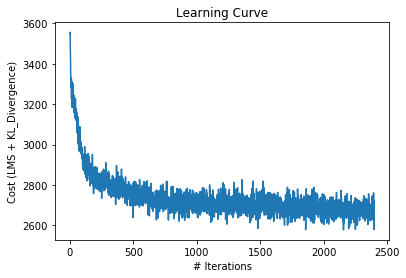

In [8]:
vae.train(fileDir=directory, epochs = 3, saveModel = False)


In [9]:
# vae.lattenCode = tf.placeholder(tf.float32, shape= [None, z_dim])
# vae.fake_images = vae.decoder(vae.lattenCode, is_training=False, reuse=True)

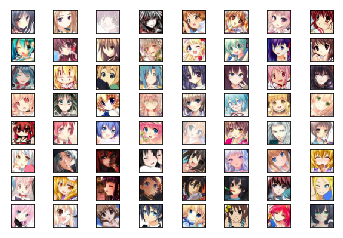

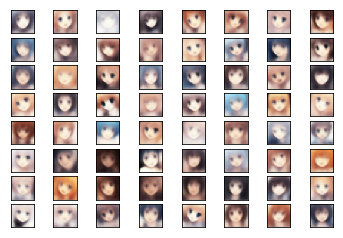

In [10]:
#
## ---------- Reconstruct Images ----------
#

sampledImgs = sampleImagesIn(directory=directory, numImgs = 64, size=(Image.size, Image.size), noiseStdev=0.0)
feed_dict_valid = {vae.inputImages : sampledImgs }
reconstructedImgs = vae.sess.run(vae.reconstruct, feed_dict=feed_dict_valid)

plotImages(sampledImgs, savePath = '../figure/VAE/origin.png')
plotImages(reconstructedImgs, savePath = '../figure/VAE/reconstruct.png')

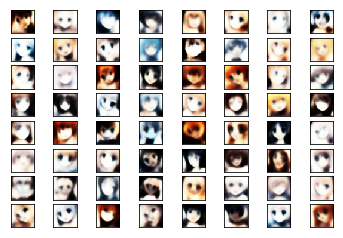

In [11]:
#
## ---------- Fake Images ----------
#


# z = np.random.normal(0, 5, size=(batch_size, z_dim))
# # z = np.random.uniform(-5, 5, size=(batch_size, z_dim))
# feed_dict_test = {vae.lattenCode : z }
# imgs = vae.sess.run(vae.fake_images, feed_dict=feed_dict_test)
imgs = vae.generateFakeImages()
plotImages(imgs, savePath = '../figure/VAE/generate.png')

In [12]:
## TODO...
# Dst tensor is not initialized Error while saving model
# saver = tf.train.Saver()
# save_path = saver.save(self.sess, "../models/model.ckpt")